#                            Final_Project_Brain_Tumor_Classifier

                  Authors: Tahir Hussain

# Project Overview and Objective:

1)The main purpose of this project was to build models that would classify if a subject has a tumor or not based on an MRI scan. The model would try to learn the pattern of Brain Tumor in the MRI scans with different conditions such as - brain shape, size of the tumor etc.



2)In addition, we would like to test the model after training, either the given image, will be able to correctly classified or not, also a person has a brain tumor or not.

# Data-Set Description:

The image data that was used for this problem is Brain MRI Images for Brain Tumor Detection from Kaggle web. It consists 253 MRI scans of two classes:

NO - no tumor, encoded as 0 - 2606 images

YES - tumor, encoded as 1 - 5285 images


# Our Techniques:

We will build a number of models based on different learning techniques to classify the brian tumor MRI images i-e:


KNN model - finding a K-nearby neighbor.

SVM model - Support Vector Machine

Random Forest model - a forest of decision trees.

CNN model - a technique we learned in the "deep learning" course that we think will give good results on the database.

# The difficulties and solutions:

There was a black frame around the brain area in the images, and we wanted to remove it in order to optimize the model's training. 
Therefore we wrote a sophisticated algorithm that finds the edges of the brain area in the image and crops according to it. 
But then we got that each image has a different size. Eventually we decided to use the resize algorithm to remove the black areas by naive way.
In our data there were images of different sizes, some in RGB and some in grayscale. 
To maintain uniformity we converted all the images to be grayscale and 64 * 64 in size.

The data has an imbalance in the amount of images that contain a tumor and those that do not. 
There are 5285 that contain a tumor and 2607 that do not. We saw that this imbalance affects the results of the CNN model. 
Therefore we solved this by giving a factor of 1.5 to the error weight of the images without the magnification
We had an overfitting in the CNN model. 
In order to overcome this we made the model less complex and limited the amount of iterations, also we add dropout of 30%.
Code:

Import all the necessary libraries:
We have used Python libraries:

sklearn

tensorflow

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import random as rn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.utils import resample

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from IPython.display import display, Image

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rs = 42 # random seed
np.random.seed(rs)
rn.seed(rs)

In [3]:
X = []
Z = []
IMG_SIZE=64

NO_DIR= 'Brain_Tumor_dataset_no'
YES_DIR= 'Brain_Tumor_dataset_yes'

In [4]:
def make_train_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        np_img=np.asarray(img)
        X.append(np_img)
        Z.append(str(label))

In [5]:
# make 'No' data
make_train_data('No',NO_DIR)
print(len(X))

100%|██████████████████████████████████████████████████████████████████████████████| 2607/2607 [00:37<00:00, 69.45it/s]

2607


In [6]:
# make 'Yes' data
make_train_data('Yes',YES_DIR)
print(len(X))

100%|█████████████████████████████████████████████████████████████████████████████| 2678/2678 [00:19<00:00, 139.27it/s]

5285


In [7]:
# Description of the data:

# Number of instances: 5285
# Number of attributes: 64*64

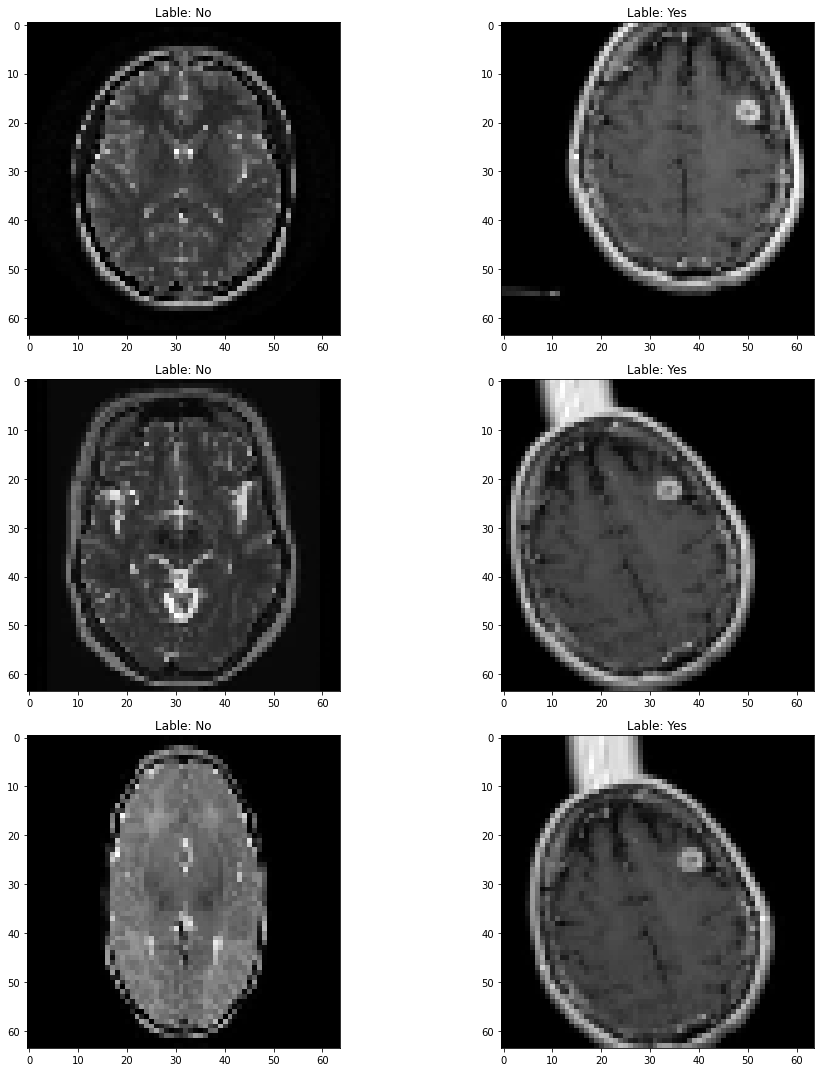

In [8]:
# check some images
fig,ax=plt.subplots(3,2)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (2):      
#         l=rn.randint(0,len(Z))
#         ax[i,j].imshow(X[l], cmap='gray')
#         ax[i,j].set_title('Lable: '+Z[l])
        if j == 0:
            ax[i,j].imshow(X[i], cmap='gray')
            ax[i,j].set_title('Lable: '+Z[i])
        else:
            ax[i,j].imshow(X[len(Z) - 1 - i], cmap='gray')
            ax[i,j].set_title('Lable: '+Z[len(Z) -1 - i])
        
plt.tight_layout()

In [9]:
# We note that some of the images have large black areas arrond the brain scan,
# thus we decided to crop the image such that only the brain scan would remain.

In [10]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    i=0
    for img in set_name:
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

                # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # add contour on the image
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

        # add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
#         if new_img.shape[0] > IMG_SIZE:
#             print('img: ', img.shape)
#             print('new_img: ', new_img.shape)
        new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE) , interpolation=cv2.INTER_CUBIC)
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        set_new.append(np.asarray(new_img))
        
        if i % 25 == 0:
            plt.figure(figsize=(15,6))
            plt.subplot(141)
            plt.imshow(img,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 1. Get the original image')
            plt.subplot(142)
            plt.imshow(img_cnt,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 2. Find the biggest contour')
            plt.subplot(143)
            plt.imshow(img_pnt,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 3. Find the extreme points')
            plt.subplot(144)
            plt.imshow(new_img,cmap='gray')
            plt.xticks([])
            plt.yticks([])
            plt.title('Step 4. Crop and resize the image')
        
        i= i+1
        plt.show()
    return set_new
    

In [11]:
# Label encoding:
# 'No' = 0

# 'Yes' = 1

In [12]:
Y = np.array(Z)
Y = np.where(Y=='No', 0, Y)
Y = np.where(Y=='Yes', 1, Y)
Y = Y.astype('int32')

In [13]:
Y

array([0, 0, 0, ..., 1, 1, 1])

# Normalization and flatten the images:

In [14]:
X = np.array([cv2.normalize(X[i], None, 0, 255, cv2.NORM_MINMAX) for i in range(len(X))]) # normalization
X=np.array(X)/255
# X = X.flatten().reshape(len(X), (IMG_SIZE ** 2) * 3) # 3 is because it is RGB image 
X = X.flatten().reshape(len(X), (IMG_SIZE ** 2))

In [15]:
#our dataset
df_y = pd.DataFrame({'target':Y})
df_X = pd.DataFrame(X)
df = pd.DataFrame(data=pd.concat([df_y, df_X], axis=1))
df

,target,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1,0,0.000000,0.000000,0.007843,0.000000,0.031373,0.035294,0.035294,0.035294,0.035294,...,0.035294,0.035294,0.035294,0.035294,0.035294,0.031373,0.000000,0.000000,0.0,0.0
2,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.023529,0.019608,0.027451,0.019608,0.023529,0.027451,0.027451,0.023529,0.0,0.0
4,0,0.211765,0.211765,0.211765,0.211765,0.211765,0.211765,0.207843,0.211765,0.266667,...,0.003922,0.007843,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5280,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5281,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5282,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
5283,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172549,0.447059,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


# Dealing with unbalcne data-set - Up-sample Minority Class:

In [16]:
# Separate majority and minority classes
df_majority = df[df.target==1]
df_minority = df[df.target==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=rs) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [17]:
df_upsampled

,target,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
2607,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2608,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2609,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2610,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.349020,0.380392,0.388235,0.192157,0.019608,0.007843,0.000000,0.000000,0.000000,0.000000
2611,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.007843,0.007843,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000
574,0,0.007843,0.003922,0.015686,0.011765,0.007843,0.011765,0.015686,0.003922,0.015686,...,0.015686,0.015686,0.003922,0.015686,0.011765,0.007843,0.003922,0.003922,0.007843,0.015686
1910,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1012,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Train Test Split

In [18]:
# separate data
X_train,X_test,y_train,y_test=train_test_split(df_upsampled.drop(['target'], axis=1), df_upsampled.target,test_size=0.20,random_state=rs, shuffle=True)

freqs = pd.DataFrame({"Training dataset": [(y_train == 1).sum(),(y_train == 0).sum()],
                      "Test dataset": [(y_test == 1).sum(),(y_test == 0).sum()],
                      "Total": [(y_train == 1).sum()+(y_test == 1).sum(),(y_train == 0).sum()+(y_test == 0).sum()]},
                     index=["Yes", "No"])
freqs[["Training dataset", "Test dataset", "Total"]]

,Training dataset,Test dataset,Total
Yes,2114,564,2678
No,2170,508,2678


In [19]:
def statistics(confusion):
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print('True Positives (TP):',TP)
    print('True Negatives (TN):',TN)
    print('False Positives (FP):',FP)
    print('False Negarives (FN):',FN)
    print('Classification Accuracy:',(TP + TN) / float(TP + TN + FP + FN))
    precision = TN / float(TN + FP)
    print('Precision:',precision)
    recall = TP / float(TP + FN)
    print('Recall:', recall)
    print('f-score:', 2 * precision * recall / (precision + recall))

In [20]:
def cm_analysis(y_true, y_pred, labels, figsize=(7,6)):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_result = pd.DataFrame(cm, index=labels, columns=labels)
    cm_result.index.name = 'Actual'
    cm_result.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='Blues')
    #plt.savefig(filename)
    plt.show()
    return cm_result, cm

# Using Support Vector Machine (SVM)


In [21]:
# Create a svm classifier:
param_grid = [
  {'C': [0.001, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear', 'sigmoid']},
 ]
svc = SVC()
svc_classifier = GridSearchCV(svc, param_grid, verbose = 1)
svc_classifier.fit(X_train, y_train)
#fit to the training data

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.001, 0.1, 1, 10, 100],
                          'kernel': ['rbf', 'linear', 'sigmoid']}],
             verbose=1)

# The best parameters for the model:

In [22]:
print(svc_classifier.best_score_)
print(svc_classifier.best_params_)

0.9794591544073544
{'C': 10, 'kernel': 'rbf'}


# Prediction:

In [23]:
y_pred = svc_classifier.predict(X_test)

In [24]:
y_pred

array([0, 1, 1, ..., 0, 1, 1])

# Confusion matrix and result report:

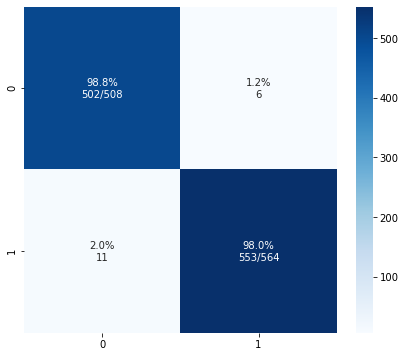

In [25]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [26]:
statistics(cm)

True Positives (TP): 553
True Negatives (TN): 502
False Positives (FP): 6
False Negarives (FN): 11
Classification Accuracy: 0.9841417910447762
Precision: 0.9881889763779528
Recall: 0.9804964539007093
f-score: 0.9843276860998632


# Using k-nearest neighbors (KNN)

In [27]:
# Create a knn classifier:
param_grid = [
  {'n_neighbors': list(range(1, 31)), 'weights': ['uniform', 'distance']},
 ]
knn = KNeighborsClassifier()
knn_classifier = GridSearchCV(knn, param_grid, verbose = 1)
knn_classifier.fit(X_train,y_train)
#fit to the training data

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

# The best parameters for the model

In [28]:
print(knn_classifier.best_score_)
print(knn_classifier.best_params_)

0.983893772014962
{'n_neighbors': 1, 'weights': 'uniform'}


# Prediction:

In [29]:
y_pred = knn_classifier.predict(X_test)
y_pred

array([0, 1, 1, ..., 0, 1, 1])

# Confusion matrix and result report:

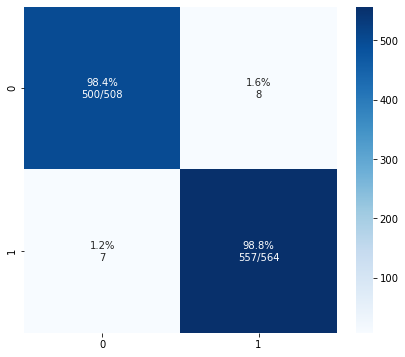

In [30]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [31]:
statistics(cm)

True Positives (TP): 557
True Negatives (TN): 500
False Positives (FP): 8
False Negarives (FN): 7
Classification Accuracy: 0.9860074626865671
Precision: 0.984251968503937
Recall: 0.9875886524822695
f-score: 0.9859174873795482


# Using Random Forest model

In [32]:
# Create a Random Forest classifier:
param_grid = { 
    'n_estimators': [10,50,100,200,500],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}
rfc = RandomForestClassifier()
rfc_classifier = GridSearchCV(rfc, param_grid, verbose = 1)
rfc_classifier.fit(X_train,y_train)
#fit to the training data

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200, 500]},
             verbose=1)

# The best parameters for the model:

In [33]:
print(rfc_classifier.best_score_)
print(rfc_classifier.best_params_)

0.9813258596058845
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}


# Prediction:

In [36]:
y_pred = rfc_classifier.predict(X_test)
y_pred

array([0, 1, 1, ..., 0, 1, 1])

# Confusion matrix and result report:

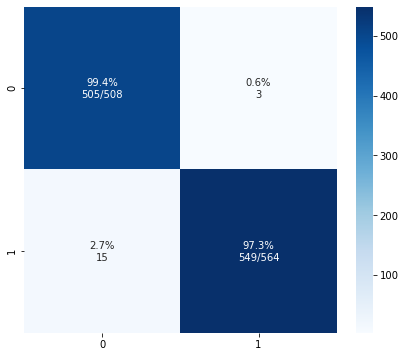

In [37]:
cm_result, cm = cm_analysis(y_test, y_pred, [0,1])

In [38]:
statistics(cm)

True Positives (TP): 549
True Negatives (TN): 505
False Positives (FP): 3
False Negarives (FN): 15
Classification Accuracy: 0.9832089552238806
Precision: 0.9940944881889764
Recall: 0.973404255319149
f-score: 0.9836405824250681


# Using Deep Learning method - CNN

Part 1 - Data Preprocessing

Split into train , test data

In [40]:
# train, test split
splitfolders.ratio('brain_tumor_dataset/', output="brain_tumor_dataset_split", ratio=(0.7, 0.3))

Copying files: 253 files [00:07, 33.83 files/s]


# Preprocessing the Training set

In [41]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train = train_datagen.flow_from_directory('./data/brain_tumor_dataset_split/train',
                                                 target_size = (IMG_SIZE,IMG_SIZE),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=True, seed=rs )



Found 183 images belonging to 2 classes.


In [42]:
train.class_indices

{'no': 0, 'yes': 1}

In [43]:
yes=np.count_nonzero(train.classes)
print("Yes:",yes)
print("No:",176-yes)

Yes: 108
No: 68


# Preprocessing the Test set

In [44]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test = test_datagen.flow_from_directory('data/brain_tumor_dataset_split/val/',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle=True, seed=rs )

Found 84 images belonging to 2 classes.


In [45]:
yes_test=np.count_nonzero(test.classes)
print("Yes:",yes_test)
print("No:",77-yes_test)

Yes: 47
No: 30


In [46]:
len(test.classes)

84

# Part 2 - Building the CNN

In [47]:
### Init the CNN model
cnn = tf.keras.models.Sequential()

### Convolution and pooling layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', input_shape=[IMG_SIZE,IMG_SIZE,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a second convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a third convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Adding a fourth convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Flattening
cnn.add(tf.keras.layers.Flatten())

### Fully Connection
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Dropout
cnn.add(tf.keras.layers.Dropout(0.3))

### Output Layer
# cnn.add(tf.keras.layers.Dense(units=2, activation='softmax'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Part 3 - Training the CNN
Compiling the CNN

In [50]:
def weighted_loss(weight):
    def weighted_cross_entropy_with_logits(labels, logits):
        loss = tf.nn.weighted_cross_entropy_with_logits( labels, logits, weight)
        return loss
    return weighted_cross_entropy_with_logits

cnn.compile(optimizer = 'adam', loss = weighted_loss(weight=1.5), metrics = ['accuracy'])
# cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Summary of the model

In [51]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 58, 58, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 16)          4

# Training the CNN on the Training set and evaluating it on the Test set

In [53]:
history=cnn.fit(x = train, epochs = 100 ,validation_data=test)

Epoch 1/100
6/6 [==============================] - 3s 459ms/step - loss: 0.7928 - accuracy: 0.6175 - val_loss: 0.7971 - val_accuracy: 0.6429
Epoch 2/100
6/6 [==============================] - 3s 430ms/step - loss: 0.7826 - accuracy: 0.6011 - val_loss: 0.7911 - val_accuracy: 0.6429
Epoch 3/100
6/6 [==============================] - 3s 474ms/step - loss: 0.7682 - accuracy: 0.6557 - val_loss: 0.7784 - val_accuracy: 0.7024
Epoch 4/100
6/6 [==============================] - 3s 420ms/step - loss: 0.7762 - accuracy: 0.6339 - val_loss: 0.7741 - val_accuracy: 0.6786
Epoch 5/100
6/6 [==============================] - 3s 443ms/step - loss: 0.7561 - accuracy: 0.7158 - val_loss: 0.7499 - val_accuracy: 0.7143
Epoch 6/100
6/6 [==============================] - 2s 415ms/step - loss: 0.7492 - accuracy: 0.6776 - val_loss: 0.7739 - val_accuracy: 0.6786
Epoch 7/100
6/6 [==============================] - 3s 426ms/step - loss: 0.7611 - accuracy: 0.6667 - val_loss: 0.7529 - val_accuracy: 0.6667
Epoch 8/100
6

Epoch 59/100
6/6 [==============================] - 2s 415ms/step - loss: 0.6448 - accuracy: 0.8689 - val_loss: 0.6686 - val_accuracy: 0.8333
Epoch 60/100
6/6 [==============================] - 3s 425ms/step - loss: 0.6620 - accuracy: 0.8251 - val_loss: 0.6732 - val_accuracy: 0.7976
Epoch 61/100
6/6 [==============================] - 2s 406ms/step - loss: 0.6580 - accuracy: 0.8470 - val_loss: 0.6770 - val_accuracy: 0.8214
Epoch 62/100
6/6 [==============================] - 2s 408ms/step - loss: 0.6395 - accuracy: 0.8852 - val_loss: 0.6568 - val_accuracy: 0.8690
Epoch 63/100
6/6 [==============================] - 3s 433ms/step - loss: 0.6459 - accuracy: 0.8579 - val_loss: 0.6626 - val_accuracy: 0.8452
Epoch 64/100
6/6 [==============================] - 3s 432ms/step - loss: 0.6743 - accuracy: 0.8142 - val_loss: 0.6465 - val_accuracy: 0.8929
Epoch 65/100
6/6 [==============================] - 3s 437ms/step - loss: 0.6561 - accuracy: 0.8361 - val_loss: 0.6916 - val_accuracy: 0.7976
Epoch 

# Train accuracy

In [54]:
cnn.evaluate(train)

6/6 [==============================] - 1s 206ms/step - loss: 0.5949 - accuracy: 0.9454


[0.5949082970619202, 0.9453551769256592]

# Test accuracy

In [55]:
cnn.evaluate(test)

3/3 [==============================] - 0s 86ms/step - loss: 0.6322 - accuracy: 0.8929


[0.6321619153022766, 0.8928571343421936]

In [56]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend()
    #plt.show()
    
    # Accuracy
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    plt.show()

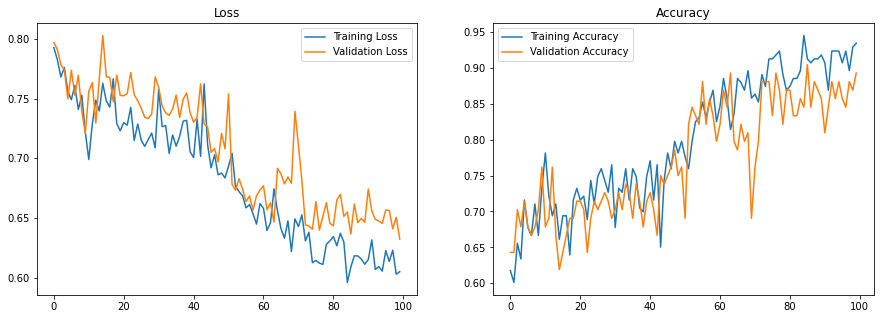

In [57]:
plot_metrics(history)

In [58]:
Y_pred = cnn.predict(test)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test.classes, y_pred))

Confusion Matrix
[[37  0]
 [47  0]]


# Part 4 - Making single predictions

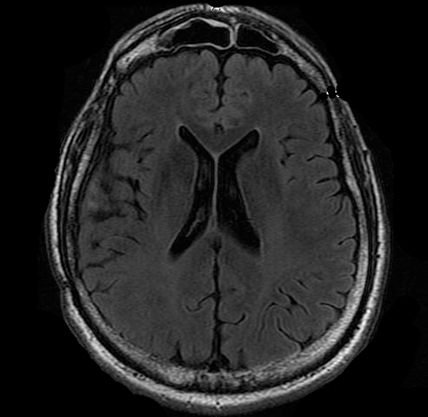

Actual: No
Predicted: No


In [59]:
display(Image(filename='./data/brain_tumor_dataset_split/val/no/7 no.jpg'))
test_image = image.load_img('./data/brain_tumor_dataset_split/val/no/46 no.jpg', target_size = (IMG_SIZE, IMG_SIZE))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
if result[0][0] == 1:
    prediction = 'Yes'
else:
    prediction = 'No'

print("Actual: No")
print("Predicted:", prediction)

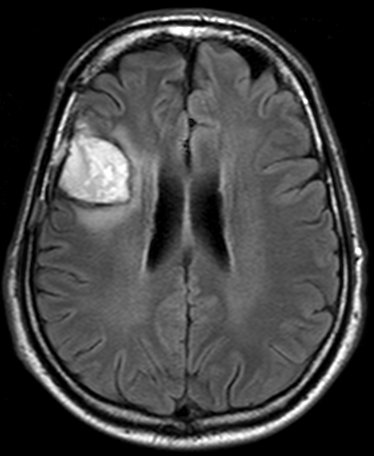

Actual: Yes
Predicted: Yes


In [61]:
display(Image(filename='./data/brain_tumor_dataset_split/val/yes/Y7.jpg'))
test_image = image.load_img('./data/brain_tumor_dataset_split/val/yes/Y7.jpg', target_size = (IMG_SIZE, IMG_SIZE))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn.predict(test_image)
train.class_indices
if result[0][0] == 1:
    prediction = 'Yes'
else:
    prediction = 'No'

print("Actual: Yes")
print("Predicted:", prediction)